# How to Prepare Your Data for AUTOENCODIX
In this tutorial we'll show how `AUTOENCODIX` deals with different types of data and the different ways to pass data into the pipeline.

**IMPORTANT**

> This tutorial mainly explains the types of data we allow and how to format the data so that AUTOENCODIX can work with it. If you're unfamiliar with general concepts,  
> we recommend following the `Getting Started - Vanillix` Tutorial first.

## What You'll Learn
We'll cover:
- Our general data logic
- How to pass data from files for different data modalities
- How to pass data directly into our pipeline
- Differences between paired and unpaired data
- How our preprocessing works and how to skip it

## Data Model Theory
There are `two main ways` to pass data to `AUTOENCODIX` and we support `three main data modalities`. For these main modalities, we offer `seven main use cases`. 
Besides that, you can choose whether we should preprocess the data or you want to start with training the models directly.

The `two main ways` to pass data are:  
- Providing a file path in the config
- Passing the data directly to our pipeline

The `three main data modalities` are:
- Tabular numeric data  
- Sparse numeric data (Single Cell) 
- Image data

The `seven main use cases` are:
- Combining multi-omics data from single cell sequencing
- Combining multi-omics data from bulk sequencing (e.g., mRNA and methylation)
- "Translating" between bulk sequencing data
- "Translating" bulk and image data, and vice versa
- "Translating" between single cell data
- Training an image autoencoder

We encode these cases in our `DataCase` class, and you need to specify in the config which `DataCase` you have. This is shown in the code in the next section.

The general way to feed data to our pipeline is independent of the specific model (Varix, XModalix, etc.). There might be minor pipeline-specific requirements; for example, for `Ontix` we won't cover these here—please refer to the tutorials of the specific pipeline. Here we use `XModalix` and `Varix` as examples.


## 1) Passing Data from File
Depending on which pipeline you use, you will be interested in one of our `seven main use cases` as described above.  

Regardless of the use case, the principle of passing data is always the same; only your file types will differ, and you need to specify the use case in the config via the `DataCase`:

```python
from enum import Enum

class DataCase(str, Enum):
    MULTI_SINGLE_CELL = "Multi Single Cell"
    MULTI_BULK = "Multi Bulk"
    BULK_TO_BULK = "Bulk<->Bulk"
    IMG_TO_BULK = "IMG<->Bulk"
    SINGLE_CELL_TO_SINGLE_CELL = "Single Cell<->Single Cell"
    SINGLE_CELL_TO_IMG = "Single Cell<->IMG"
    IMG_TO_IMG = "IMG<->IMG"  # standard image autoencoder
```
#### 1.1 Combining Multi-Omics Data from Bulk-Sequencing
First, we need to prepare our config object. We can either (a) directly provide a Python object, or (b) provide a YAML file. Here, we show option (a). For option (b), refer to [1].

**ATTENTION:**  
If you use `.txt` or `.csv` files, it is best practice to add the `sep` parameter. If none is given, the reader will try to auto-detect the separator, which is error-prone. This would look like:

**IMPORTANT:**  
> For all your bulk data files, we expect the first column to be some kind of unique sample ID. Please prepare the data accordingly.

[1] `Tutorials/DeepDives/ConfigTutorial.ipynb`


**First make sure we are in the root of our package:**

In [1]:
import os

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")


Changed to: /Users/maximilianjoas/development/autoencodix_package


**Now we can prepare the config:**  
> Besides the actual data files, we expect one `annotation` file with metadata. We add the parameter `data_type` and set it to `ANNOTATION`, as shown in the code below.  
> If you have columns inside the `ANNOTATION` data that you want to use later in downstream visualization or evaluation tasks, please specify them with the `annotation_columns` parameter of the `DataConfig`. This will prevent errors later, as NaNs will be handled automatically during preprocessing for these columns.



#### ❗❗ Requirements: Getting Tutorial Data ❗❗
Attention the data for the first example (bulk sequencing) is rather large (8GB). We will update this Tutorial in the future with a smaller dataset. If you want to follow along anyway, you can download the data here:
https://cloud.scadsai.uni-leipzig.de/index.php/s/6LsctJ9Cmr9Hndt
> Make sure you select the files accordingly (see cell below and place them into `data/raw`)
This will be more user friendly in the future.

reading parquet: data/raw/data_mrna_seq_v2_rsem_formatted.parquet
reading parquet: data/raw/data_methylation_per_gene_formatted.parquet
reading parquet: data/raw/data_clinical_formatted.parquet
anno key: paired


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_trainer.py:118: UserWarning: increased batch_size to 33 for trainset, to avoid dropping samples and having batches (makes trainingdynamics messy with missing samples per epoch) of size one (fails for Models with BachNorm)
  warnings.warn(


Epoch 1 - Train Loss: 22.4608
Sub-losses: recon_loss: 22.4608, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 18.2064
Sub-losses: recon_loss: 18.2062, var_loss: 0.0002, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 19.4772
Sub-losses: recon_loss: 19.4457, var_loss: 0.0315, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 2 - Valid Loss: 15.7164
Sub-losses: recon_loss: 15.6724, var_loss: 0.0440, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 3 - Train Loss: 18.6787
Sub-losses: recon_loss: 17.9482, var_loss: 0.7305, anneal_factor: 0.9656, effective_beta_factor: 0.0966
Epoch 3 - Valid Loss: 14.4565
Sub-losses: recon_loss: 13.8964, var_loss: 0.5601, anneal_factor: 0.9656, effective_beta_factor: 0.0966
Creating plots ...


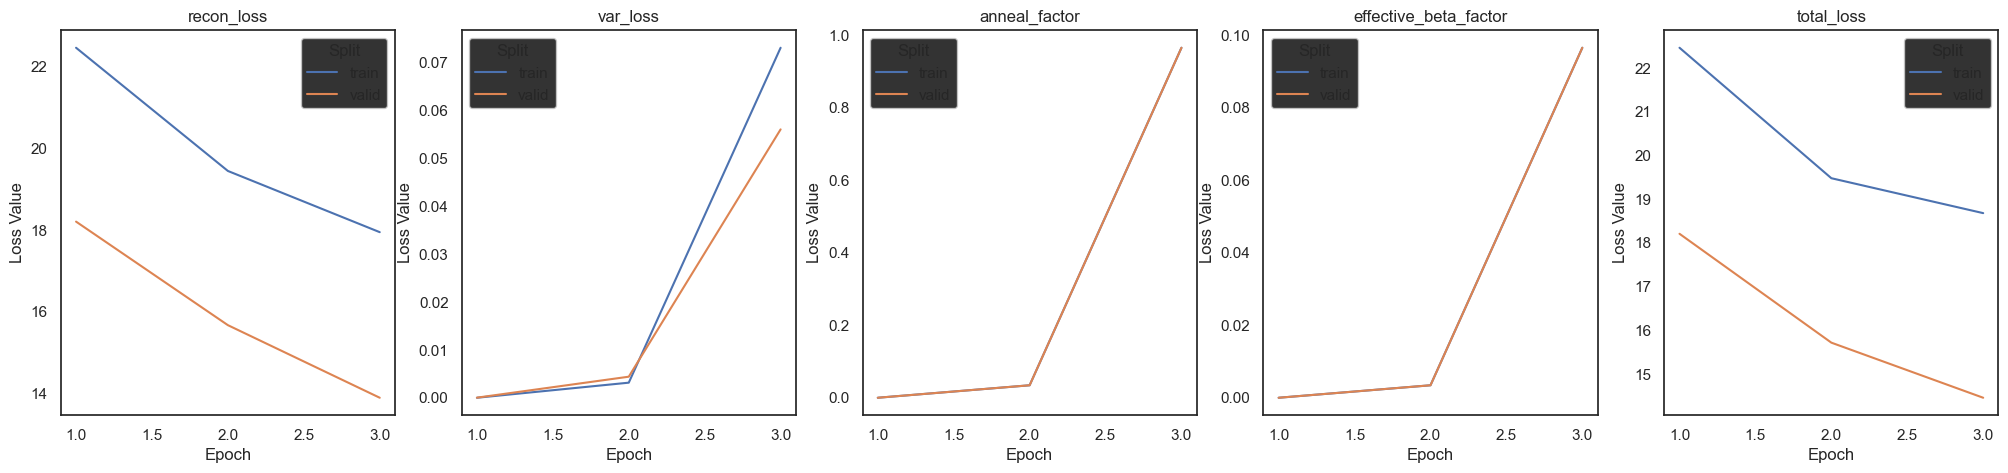

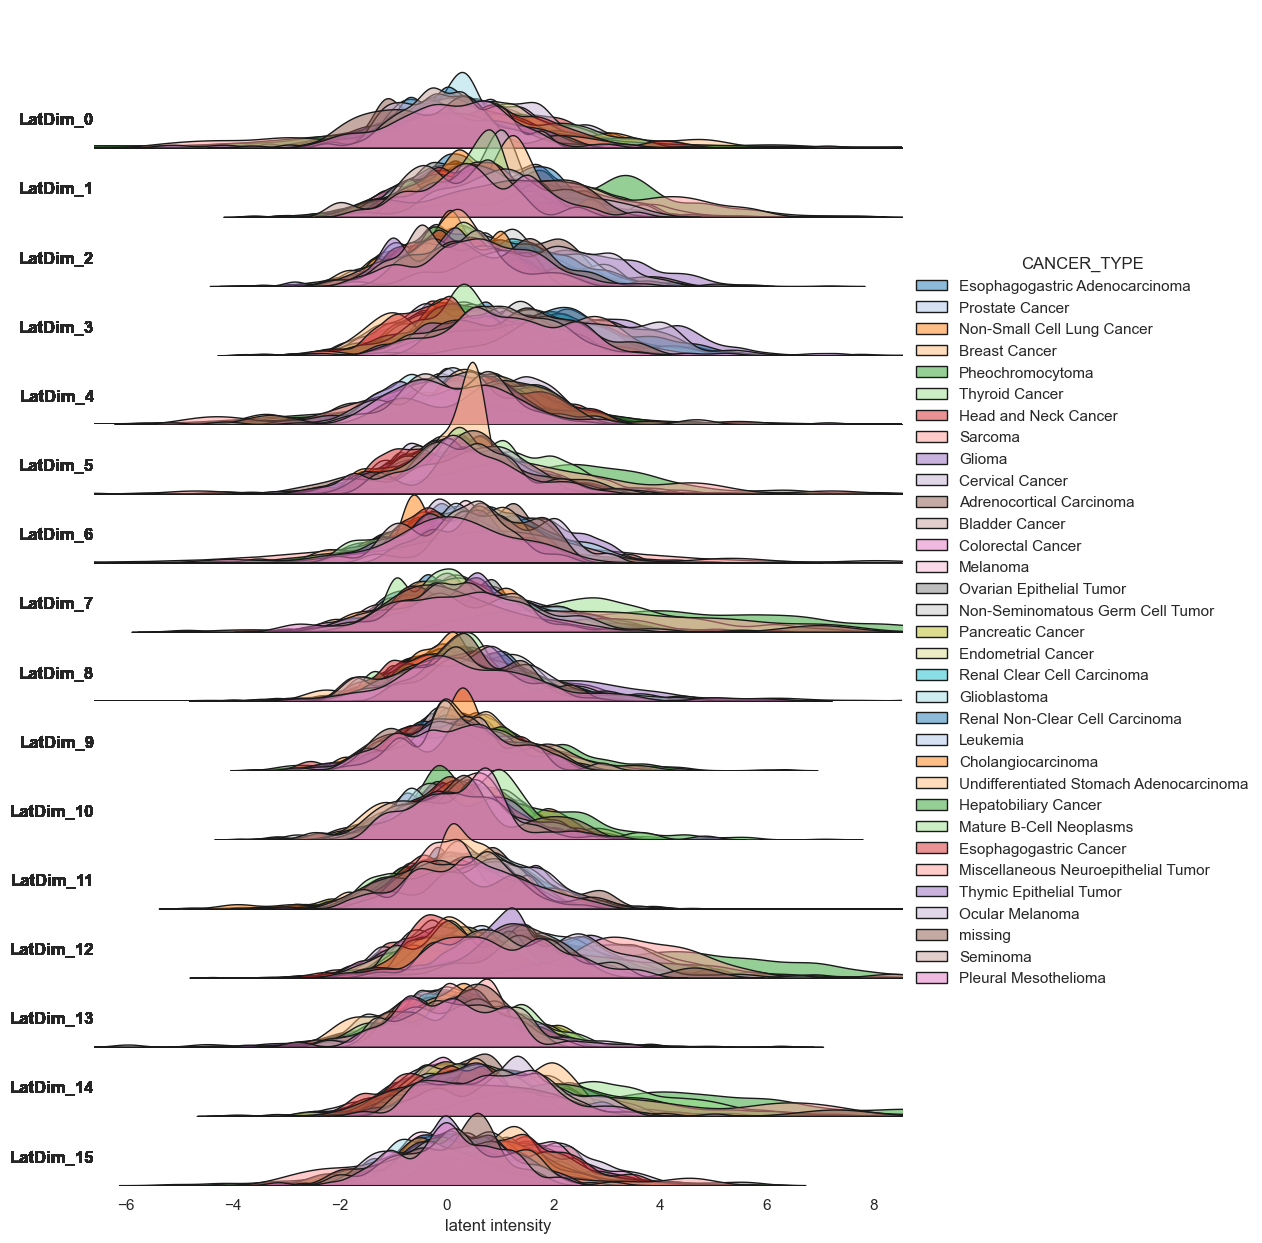

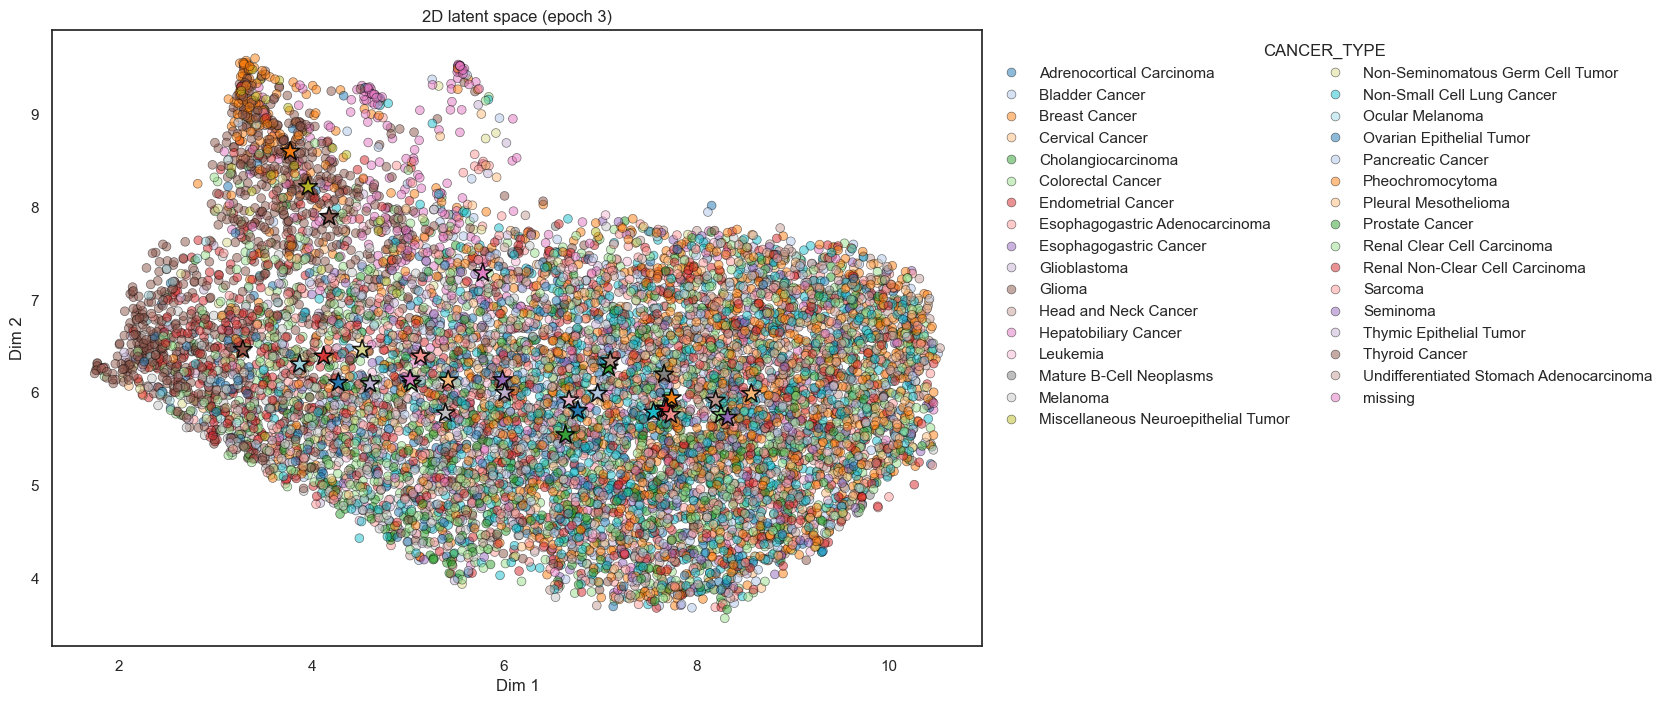

In [ ]:
import os
import autoencodix as acx
from autoencodix.configs.default_config import DataConfig, DataInfo, DataCase
from autoencodix.configs import VarixConfig

# First we need to define our file paths
root_dir = os.path.join("data/raw")
meth_file = "data_methylation_per_gene_formatted.parquet"
mrna_file = "data_mrna_seq_v2_rsem_formatted.parquet"
clin_file = "data_clinical_formatted.parquet"
sc_filepath = "data/raw/Sc-2-mini.h5ad"


"""
Our config class has the attribute `data_config`.
Here, we fill the `data_info` Dict, by defining names for our data modalities ("RNA" for example).
The value of this Dict is a instance of the `DataInfo` class. All we need to pass here is a `file_path` argument.
"""
data_config = DataConfig(
    annotation_columns=["CANCER_TYPE"],
    data_info={
        "RNA": DataInfo(file_path=os.path.join(root_dir, mrna_file)),
        "METHYLATION": DataInfo(file_path=os.path.join(root_dir, meth_file)),
        "CLINICAL": DataInfo(
            file_path=os.path.join(root_dir, clin_file), data_type="ANNOTATION"
        ),
    },
)

"""
Lastly, we pass our data_config to the VarixConfig. Remember to pass the appropriate `DataCase`.
"""
bulk_config = VarixConfig(data_config=data_config, data_case=DataCase.MULTI_BULK, epochs=30)
varix = acx.Varix(config=bulk_config)

result_varix = varix.run()
varix.show_result()

#### 1.1.1 All Options for Data Specifc Parameters

Inside the `DataInfo` object we set the file_path, but there are way more custom data parameters that we can set. Here's a complete list of all parameters you can set in the `DataInfo` class:


##### **DataInfo General**

| **Parameter** | **Type** | **Description** |
|----------------|-----------|-----------------|
| `file_path` | `str` | Path to the raw data file |
| `data_type` | `Literal['NUMERIC', 'CATEGORICAL', 'IMG', 'ANNOTATION']` | Type of data modality |
| `scaling` | `Literal['STANDARD', 'MINMAX', 'ROBUST', 'MAXABS', 'NONE', 'NOTSET']` | Overrides the globally set scaling method for this modality |
| `filtering` | `Literal['VAR', 'MAD', 'CORR', 'VARCORR', 'NOFILT', 'NONZEROVAR']` | Feature filtering method |
| `sep` | `Optional[str]` | Delimiter for CSV/TSV input files (passed to `pandas.read_csv`) |
| `extra_anno_file` | `Optional[str]` | Path to an additional annotation file |

---

##### **Single-Cell Specific Parameters**

| **Parameter** | **Type** | **Description** |
|----------------|-----------|-----------------|
| `is_single_cell` | `bool` | Whether the dataset represents single-cell data |
| `min_cells` | `float` | Minimum fraction of cells in which a gene must be expressed to be kept (filters rare genes) |
| `min_genes` | `float` | Minimum fraction of genes a cell must express to be kept (filters low-quality cells) |
| `selected_layers` | `List[str]` | Layers to include from the single-cell dataset; must always include `"X"` |
| `is_X` | `bool` | Whether the data originates from the `"X"` matrix only |
| `normalize_counts` | `bool` | Whether to normalize single-cell counts by total expression per cell |
| `log_transform` | `bool` | Whether to apply `log1p` transformation after normalization |
| `k_filter` | `Optional[int]` | Automatically set based on global config; do not override manually |

---

###### **Image-Specific Parameters**

| **Parameter** | **Type** | **Description** |
|----------------|-----------|-----------------|
| `img_width_resize` | `Optional[int]` | Target width for image resizing (must equal height) |
| `img_height_resize` | `Optional[int]` | Target height for image resizing (must equal width) |

---

###### **XModalix & Translation Parameters**

| **Parameter** | **Type** | **Description** |
|----------------|-----------|-----------------|
| `translate_direction` | `Optional[Literal['from', 'to']]` | Defines translation direction in cross-modal (XModalix) training |
| `pretrain_epochs` | `int` | Number of pretraining epochs specific to this modality (overrides global pretraining setting) |


#### 1.2 Use Single Cell Data
This works analogously to bulk/tabular data. You will most likely pass `h5ad` files instead of parquet or CSV files.  
For single cell data, you typically use only one data modality, so the term `MULTI_SC` in our `DataCase` may be a bit misleading; think of it as supporting 1–n modalities. Also, you most likely won't have a separate `annotation` file, because this information is already encoded in the `h5ad` file.

**Note:**  
> It is best practice to add the `is_single_cell` parameter to the `DataInfo` of the modality.


In [4]:
filepath = "data/raw/Sc-2-mini.h5ad"
data_config = DataConfig(
    annotation_columns=["cell_type"],
    data_info={"SC": DataInfo(file_path=filepath, is_single_cell=True)},
)
sc_config = VarixConfig(data_config=data_config, data_case=DataCase.MULTI_SINGLE_CELL)
varix_sc = acx.Varix(config=sc_config)
result_sc = varix_sc.run()

Number of common cells: 4554
Index(['author_cell_type', 'age_group', 'donor_id', 'nCount_RNA',
       'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile',
       'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id',
       'cell_type_ontology_term_id', 'development_stage_ontology_term_id',
       'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id', 'suspension_type', 'is_primary_data',
       'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism',
       'sex', 'tissue', 'self_reported_ethnicity', 'development_stage',
       'observation_joinid'],
      dtype='object')
mudata: View of MuData object with n_obs × n_vars = 4554 × 9009
  obs:	'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_t

**Special Case for Visualization**  
As explained before, we can define one or more columns to use for visualization. In our example, we chose the `cell_type` column. Internally, the column gets prefixed with the name of the data modality defined in the `DataInfo` dict. Therefore, to visualize this column, we need to add the prefix to the column name, e.g., `SC:cell_type`.  

> This will likely be fixed in the future, allowing you to pass the column name without the prefix.


Creating plots ...


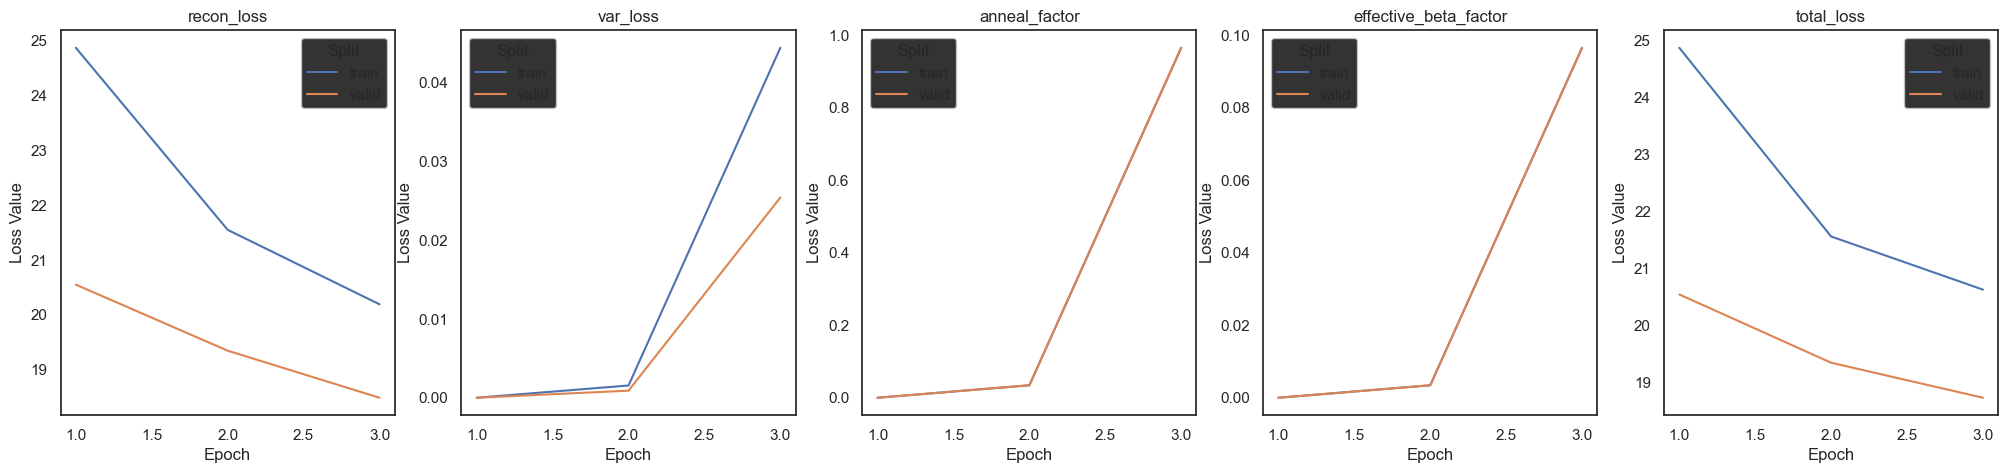

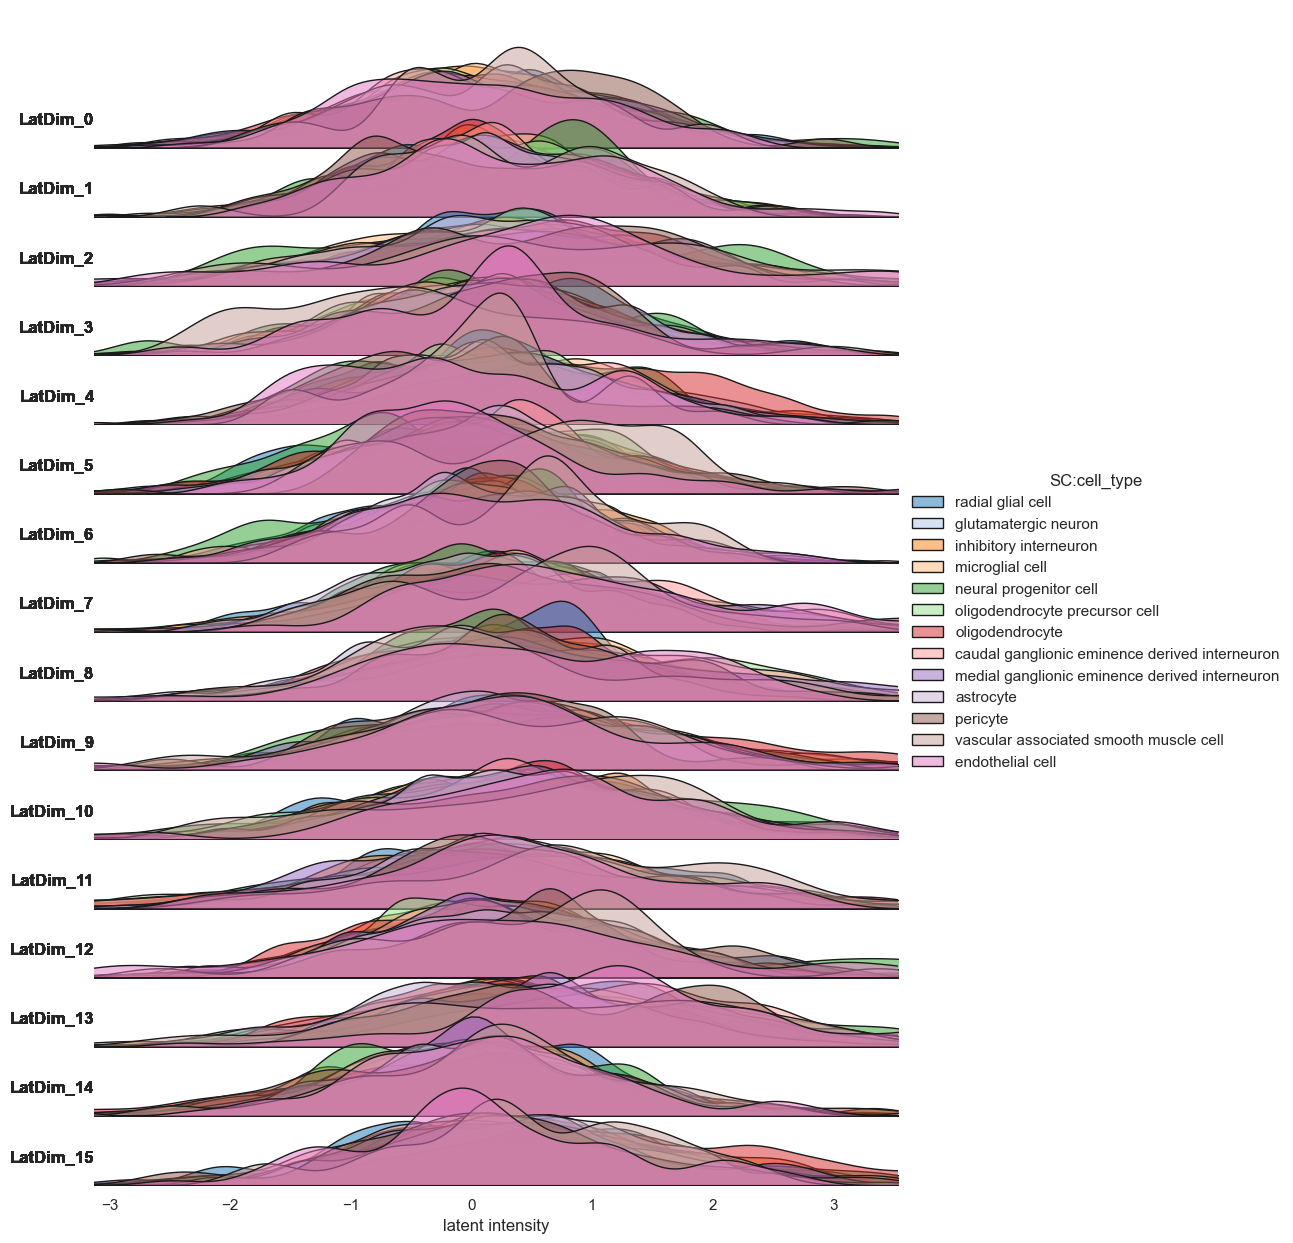

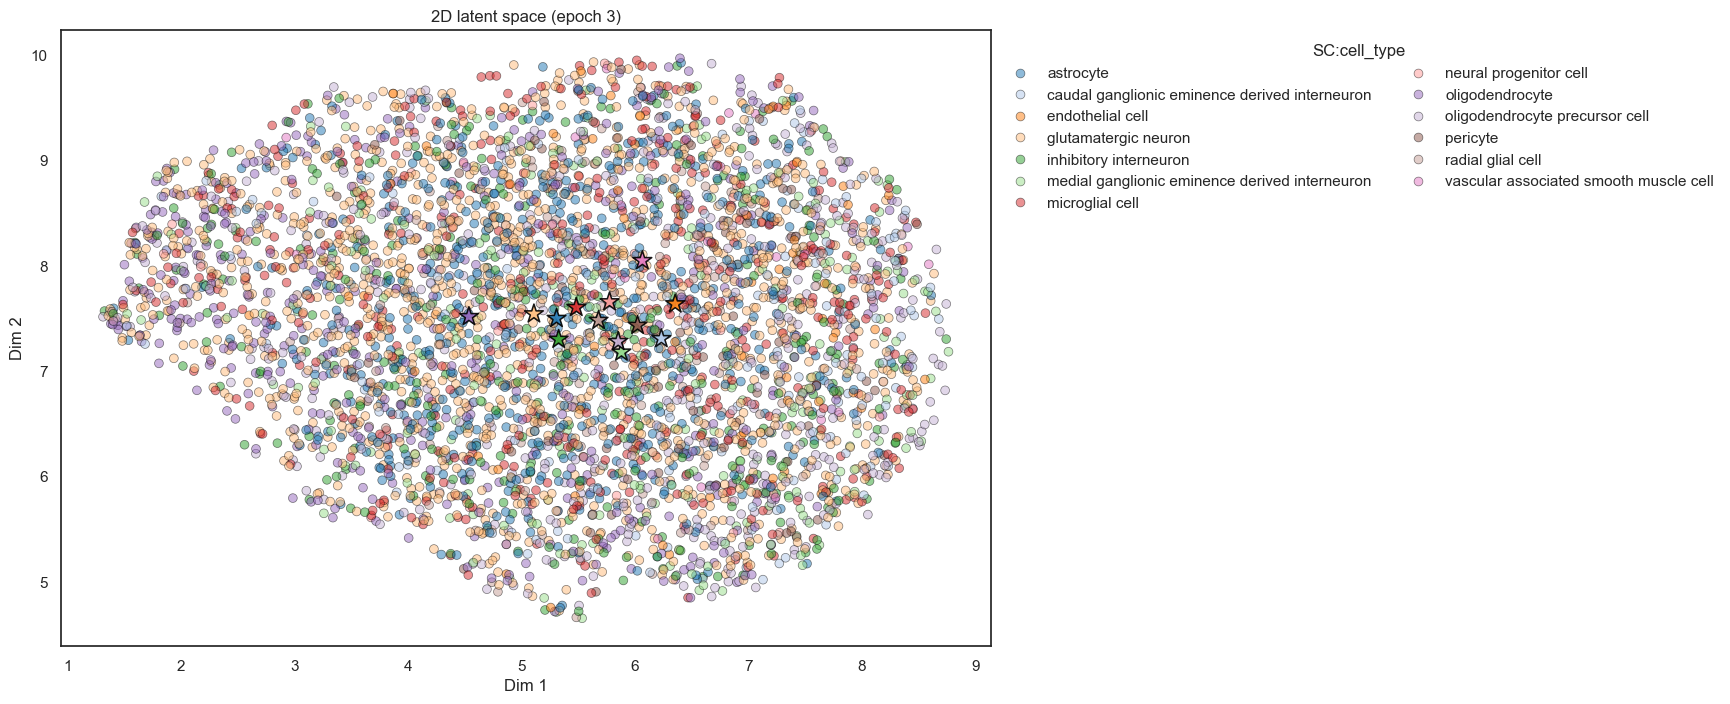

In [5]:
varix_sc.show_result(params=["SC:cell_type"])

#### 1.3 Working with Images

Working with images is similar to the previous cases. The main differences are:

- You need to provide a **directory path** where the image files are located, instead of a path to a single file.  
- You need to **match each image path to a `sample_id`**, so that we know which metadata belongs to which image.  
  - This is done via the annotation file. The annotation file should have one column containing only the image file name (e.g., `image.jpg`, NOT `mydir/image.jpg`). The name of this column must be passed to the `img_path_col` parameter in the config.

We support the following image file extensions (case-insensitive):  
`".jpg", ".jpeg", ".png", ".tif", ".tiff"`  
Ensure the directory you specify contains files with these supported extensions.

Optionally, you can specify an **image size** (only square dimensions are allowed).

#### ❗❗ Requirements: Getting Tutorial Data 2❗❗

You can use the following bash commands to download the data and set up the correct folder structure.  This will download 400 MB of data.
**Assumption:** you are in the root of `autoencodix_package`.

```bash
mkdir -p data
cd data
wget "https://cloud.scadsai.uni-leipzig.de/index.php/s/bq64MaQyZGZfN64/download/XModalix-Tut-data.zip"
unzip XModalix-Tut-data.zip
```

In [6]:
from autoencodix.configs import XModalixConfig
import os
import autoencodix as acx
from autoencodix.configs.default_config import DataConfig, DataInfo, DataCase

from autoencodix.configs import VarixConfig


clin_file = os.path.join("data/XModalix-Tut-data/combined_clin_formatted.parquet")
rna_file = os.path.join("data/XModalix-Tut-data/combined_rnaseq_formatted.parquet")
img_root = os.path.join("data/XModalix-Tut-data/images/tcga_fake")

xmodalix_config = XModalixConfig(
    img_path_col="img_paths", # col in your annnotation file
    checkpoint_interval=5,
    class_param="CANCER_TYPE_ACRONYM",
    epochs=30,
    requires_paired=False,
    pretrain_epochs=10,
    skip_preprocessing=True,
    data_case=DataCase.IMG_TO_BULK,
    data_config=DataConfig(
        data_info={
            "img": DataInfo(
                file_path=img_root,
                data_type="IMG",
                scaling="MINMAX",
                translate_direction="to",  # For XModalix you need to specify "to" or "from"
                img_width_resize=32,
                img_height_resize=32,
                # extra_anno_file=imganno_file,
            ),
            "rna": DataInfo(
                file_path=rna_file,
                data_type="NUMERIC",
                scaling="MINMAX",
                translate_direction="from",
            ),
            "anno": DataInfo(file_path=clin_file, data_type="ANNOTATION", sep="\t"),
        },
    ),
)

xmodalix = acx.XModalix(config=xmodalix_config)
result = xmodalix.run()

reading parquet: data/XModalix-Tut-data/combined_rnaseq_formatted.parquet
reading parquet: data/XModalix-Tut-data/combined_clin_formatted.parquet
Given image size is possible, rescaling images to: 32x32
Successfully loaded 3230 images for img
anno key: rna
anno key: img
Converting 2261 images to torch.float32 tensors...
Converting 646 images to torch.float32 tensors...
Converting 323 images to torch.float32 tensors...
key: train, type: <class 'dict'>
key: valid, type: <class 'dict'>
key: test, type: <class 'dict'>
Dataset has UNPAIRED samples → using CoverageEnsuringSampler (2261 paired + 225 unpaired)
Dataset has UNPAIRED samples → using CoverageEnsuringSampler (323 paired + 32 unpaired)
Check if we need to pretrain: multi_bulk.rna
pretrain epochs : 10
Starting Pretraining for: multi_bulk.rna with <class 'autoencodix.trainers._general_trainer.GeneralTrainer'>
Epoch 1 - Train Loss: nan
Sub-losses: recon_loss: nan, var_loss: nan, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoc

len of tensor-list: 711
len of tensor_ids: 711


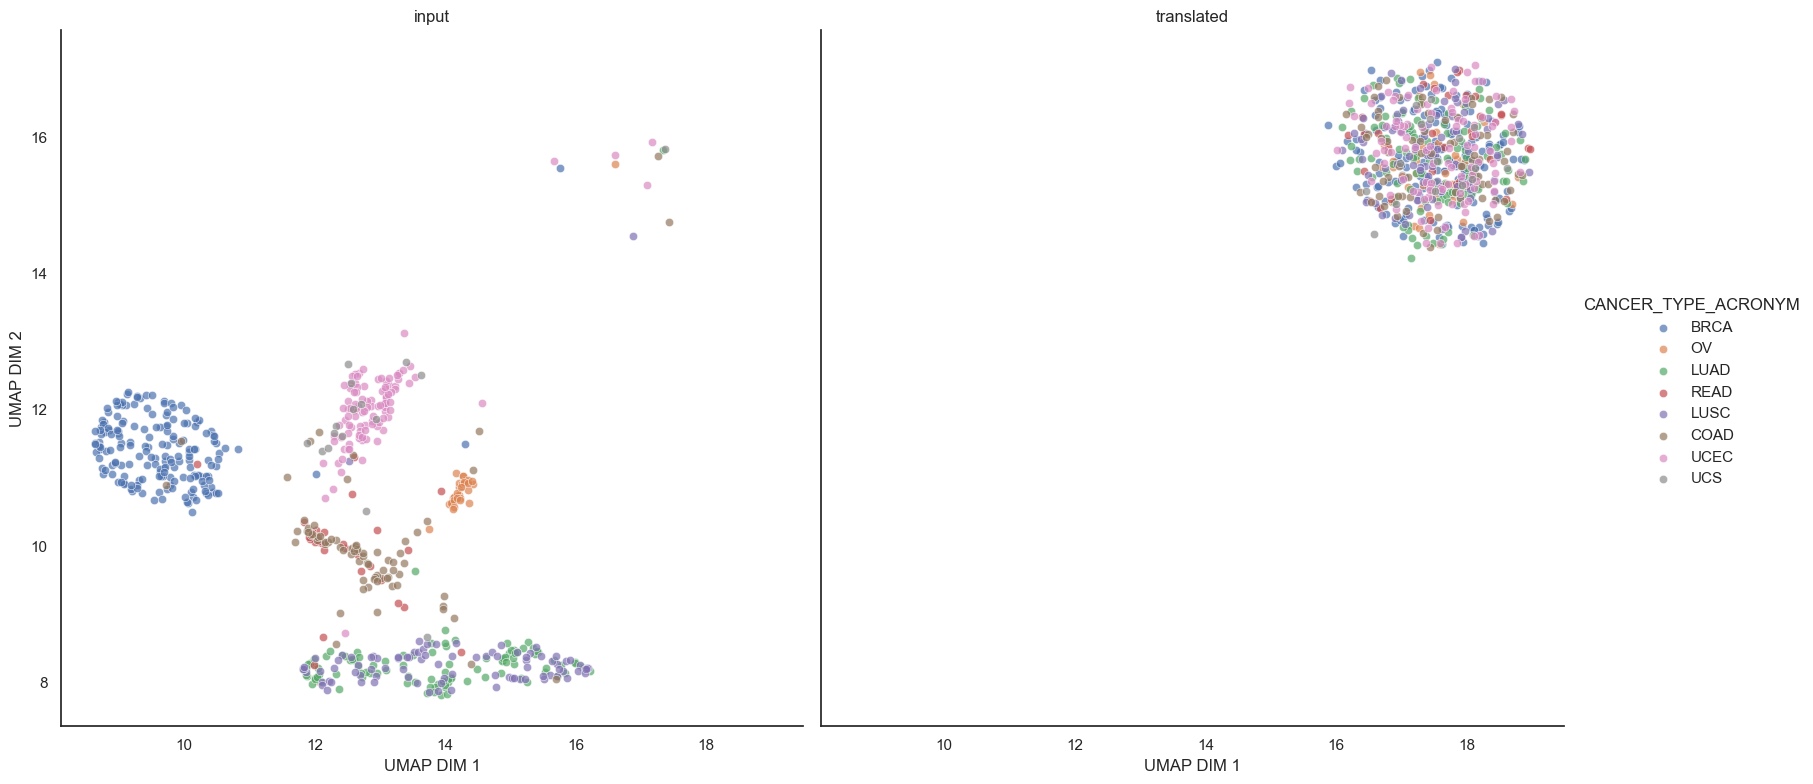

In [7]:
fig = xmodalix.visualizer.show_2D_translation(
    result=result,
    translated_modality="img.img",
    split="test",
    param="CANCER_TYPE_ACRONYM",
    reducer="UMAP",
)

## 2) Passing Data Directly
If you want to provide the data yourself, or the data comes from another script directly as a Python object, we show how to prepare it for `AUTOENCODIX`.  
We will go over our `three main data modalities` as in the previous section.

The main class for this is the `DataPackage` class. This serves as a container for `pandas` DataFrames and `AnnData`/`MuData`.  
Let's see in code how this works to make things clearer:


#### 2.1) Passing Numeric Tabular Data
Let's assume we have two data modalities as `pd.DataFrame`s and one annotation file with metadata, also as a `pd.DataFrame`.  
The only requirement for the data files is that they are numeric. For the annotation file, categorical variables are also allowed.


In [8]:
from autoencodix.utils.example_data import raw_protein, raw_rna, annotation
from autoencodix.data import DataPackage

print(f"Type of rna: {type(raw_rna)}")
raw_protein.head()

Type of rna: <class 'pandas.core.frame.DataFrame'>


,protein_0,protein_1,protein_2,protein_3,protein_4,protein_5,protein_6,protein_7,protein_8,protein_9,...,protein_70,protein_71,protein_72,protein_73,protein_74,protein_75,protein_76,protein_77,protein_78,protein_79
sample_0,-12.042401,0.087191,-2.569039,1.194324,3.232265,-0.849021,-2.456986,-4.714146,-0.330510,1.791241,...,1.298304,-0.888675,2.211052,0.704696,2.647467,3.053971,1.389405,-1.531050,-0.931632,-8.202654
sample_1,-5.774403,0.189626,-4.880973,0.945787,1.178465,-5.730645,-2.277935,-1.755148,-4.730100,0.394876,...,-4.046358,-3.408130,3.022748,-0.314424,2.378629,0.222959,-0.101802,4.570407,0.801779,-5.779545
sample_2,2.853659,-1.509067,-0.102335,-0.900886,-1.202590,1.023140,-0.556068,-0.431105,-3.262940,-0.705130,...,2.127268,2.228164,0.949771,0.055224,-5.031155,-2.850230,-3.012782,1.672382,0.657073,-0.844778
sample_3,3.409531,-0.221087,1.766617,3.460660,-1.476767,-0.344091,-3.543586,3.578511,-0.855364,2.385952,...,-2.032749,-1.866859,-0.718189,0.603248,2.518338,-0.300170,-3.655031,1.102813,0.516071,1.866424
sample_4,2.056824,-7.165520,1.986310,-2.968593,2.047759,-6.310128,2.237384,1.204833,-3.900744,0.986285,...,-2.756762,-2.793976,4.341621,-4.084905,-2.004152,7.571476,5.221252,1.209981,1.946205,-3.417621


In our `DataPackage` class we have four attributes:

- `multi_bulk`: any tabular numeric data goes here  
- `multi_sc`: single-cell data  
- `annotation`: metadata for samples  
- `img`: image data  

Each attribute holds a `Dict`, where you can pass your `DataFrame`s (or AnnData/MuData) and assign a data modality key, like:


In [9]:
my_dp = DataPackage(
    multi_bulk={"rna": raw_rna, "protein": raw_protein}, annotation={"anno": annotation}
)

The instance of `DataPackage` can be directly passed to our pipeline object via the data keyword argument.

In [10]:
import os
import autoencodix as acx
from autoencodix.configs.default_config import DataConfig, DataInfo, DataCase
from autoencodix.configs import VarixConfig

config = VarixConfig(data_case=DataCase.MULTI_BULK, epochs=30)
varix = acx.Varix(data=my_dp, config=config)
result = varix.run()

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
anno key: anno
Epoch 1 - Train Loss: 28.7099
Sub-losses: recon_loss: 28.7098, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 23.1685
Sub-losses: recon_loss: 23.1685, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 27.0684
Sub-losses: recon_loss: 27.0684, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 24.0318
Sub-losses: recon_loss: 24.0318, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 3 - Train Loss: 26.0246
Sub-losses: recon_loss: 26.0246, var_loss: 0.0001, anneal_factor: 0.0002, effective_beta_factor: 0.0000
Epoch 3 - Valid Loss: 23.9921
Sub-losses: recon_loss: 23.9921, var_loss: 0.0000, anneal_factor: 0.0002, effective_beta_factor: 0.0000
Epoch 4 - Train Loss: 24.8310
Sub-losses: recon_loss: 24.8308, var_loss: 0.0001, anneal_fact

You still can customize your config by providing a `DataConfig` with `DataInfo` as shown in [section 1](#11-combining-mulit-omics-data-from-bulk-sequencing).

In [11]:
my_dp = DataPackage(
    multi_bulk={"rna": raw_rna, "protein": raw_protein}, annotation={"anno": annotation}
)
data_config = DataConfig(
    data_info={
        "rna": DataInfo(scaling="MINMAX"),
        "protein": DataInfo(scaling="MINMAX"),
    },
)

bulk_config = VarixConfig(data_config=data_config, data_case=DataCase.MULTI_BULK, epochs=30)
varix = acx.Varix(config=bulk_config, data=my_dp)
r = varix.run()

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
anno key: anno
Epoch 1 - Train Loss: 9.9785
Sub-losses: recon_loss: 9.9784, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 5.8141
Sub-losses: recon_loss: 5.8141, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 8.4208
Sub-losses: recon_loss: 8.4207, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 5.1264
Sub-losses: recon_loss: 5.1264, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 3 - Train Loss: 7.1513
Sub-losses: recon_loss: 7.1512, var_loss: 0.0001, anneal_factor: 0.0002, effective_beta_factor: 0.0000
Epoch 3 - Valid Loss: 5.0640
Sub-losses: recon_loss: 5.0639, var_loss: 0.0000, anneal_factor: 0.0002, effective_beta_factor: 0.0000
Epoch 4 - Train Loss: 6.4198
Sub-losses: recon_loss: 6.4197, var_loss: 0.0001, anneal_factor: 0.0003, ef

#### 2.2) Passing Single Cell Data
This works analogously to the numeric tabular case above. Instead of `pd.DataFrame`s, we pass `AnnData` or `MuData` objects (from `scverse`) to our `DataPackage`.  

It is also possible to pass `AnnData` or `MuData` directly to the pipeline.


**Working with AnnData**

In [12]:
from autoencodix.utils.example_data import sample_adata, sample_mudata

sample_adata

AnnData object with n_obs × n_vars = 1000 × 500
    obs: 'cell_type', 'batch', 'donor', 'cell_cycle'

For `AnnData`, this is now actually super simple: you can just pass the `AnnData` object directly to the pipeline, without specifying the `DataCase` for `Varix`, because we can infer it from the pipeline type and the input data type. 

In this example, we did not pass a config, which means the pipeline will use default parameters.  

Of course, you can also define and pass a custom config if needed.


In [13]:
varix = acx.Varix(data=sample_adata)
result = varix.run()

in handle_direct_user_data with data: <class 'anndata._core.anndata.AnnData'>
mudata: View of MuData object with n_obs × n_vars = 1000 × 500
  1 modality
    user-data:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc
Epoch 1 - Train Loss: 27.4906
Sub-losses: recon_loss: 27.4906, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 18.2522
Sub-losses: recon_loss: 18.2522, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 24.9438
Sub-losses: recon_loss: 24.9261, var_loss: 0.0177, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 2 - Valid Loss: 18.2368
Sub-losses: recon_loss: 18.2296, var_loss: 0.0072, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 3 - Train Loss: 24.1511
Sub-l

**Working with MuData**  
In some cases, you may want to combine multiple single-cell modalities. Here, we expect a `MuData` object. This can be passed directly to the pipeline, as shown for `AnnData`, or via our `DataPackage`, as shown in the tabular numeric case.


In [14]:
sample_mudata

MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'

In [15]:
varix = acx.Varix(data=sample_mudata)
result = varix.run()

in handle_direct_user_data with data: <class 'mudata._core.mudata.MuData'>
mudata: View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc
Epoch 1 - Train Loss: 28.6608
Sub-losses: recon_loss: 28.6608, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 19.9480
Sub-losses: recon_loss: 19.9480, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 25.6774
Sub-losses: recon_loss: 25.6625, var_loss: 0.0149, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 2 - Valid Loss: 19.7316
Sub-losses: recon_loss: 19.7240, var_loss: 0.0076, anneal_factor: 0

**Single Cell Specific Processing**
TODO

#### 2.3) Passing Image Data
We recommend passing image data via a folder path in the config, as shown in [Section 1.3](#13-working-with-images).  
For completeness, we show how one could pass images directly to the pipeline, but this is not recommended.  

We store image data as a list, where each item represents one image and is of our custom class `ImgData`.


In [16]:
from autoencodix.data import ImgData
from autoencodix.data.datapackage import DataPackage
import numpy as np
import pandas as pd

imgdata = [ImgData(img=np.array(1), sample_id="myImg", annotation=pd.DataFrame())]
dp = DataPackage({"IMG": imgdata})
# in real applications this will be a longer list of images

## 3) Note on Paired and Unpaired Data
When working with mutli-modal data it is common that not all data modalities are present for all samples. For most the models `Vanillix`, `Varix`, and `Ontix`, we require paired data due to inherent architecture constraints and remove samples that are not present in all data modalities.  

For the models `XModalix` and `Stackix` don't have the same arechitectural constraints. Thus, we can allow also unpaired data. This needs to be specified in the config via the param `requires_paired=False`.

## 4) Notes on Data Modality Specific Preprocessing and Skipping Preprocessing

Depending on the data modality, our pipeline applies different preprocessing steps. We provide an overview of applied preprocessing techniques for our `three main data modalities`.

#### 4.1 Preprocessing for Tabular Numeric Data
The following steps are applied in order:
- Remove missing and NaN values from tabular numeric data.
- Consolidate missing and NaN values to one "missing" class for the annotation columns (as specified with the `annotation_columns` parameter in config) of the annotation dataframe.
- Split data into train/validation/test sets according to the ratios defined in the config.
- Filter features based on the method defined in the config. The statistical operations to filter the data are performed on the train set to avoid data leakage. The learned filtering from the train set is then applied to the validation and test sets.
- Fit a `sklearn` scaler on the train data, depending on the defined scaling algorithm (MinMax, Standard, etc.). The fitted scaler is then applied to the validation and test sets.
    - Filtering and scaling are also applied if you run the predict step with new unseen data.
- Transform the data into a PyTorch dataset to be ready for training with `nn.Module`.

#### 4.2 Preprocessing for Sparse Numeric Data (Single Cell)
The following steps are performed in order:
- Replace missing values with zeros.
- Apply two single-cell-specific processing steps if defined in the config:
    - Filter cells based on a gene count, defined in `min_genes` in the config via `sc.pp.filter_cells`.
    - Log-transform, if specified in config under `log_transform` via `sc.pp.log1p`.
- After this, follow the preprocessing for tabular numeric data (see above).
- Keep the data sparse in our PyTorch dataset until batch level. This prevents out-of-memory errors for large datasets when transforming from sparse to dense.

#### 4.3 Preprocessing for Image Data
For image data, preprocessing is as follows:
- Split data into train/validation/test sets as defined in the config.
- Resize images to a quadratic image size that fits our encoder depth or to the specified width and height in the config.
- Scale pixels depending on the defined scaling algorithm (MinMax, Standard, etc.) specific to images, not using `sklearn`.
- Transform data into a PyTorch dataset specialized for image data.

#### 4.4 Skipping Preprocessing
Preprocessing can be skipped via the config parameter `skip_preprocessing`. However, we cannot guarantee that there won't be `RuntimeErrors`.  
Errors should not occur if your data does not contain `NaNs` and your loss function matches the scaling. For example, if you set `reconstruction_loss` to `bce`, ensure your input data is between 0 and 1, because the last layer of our architecture is a Sigmoid.


## 5) Adding Custom Splits

Our standard preprocessing splits the data randomly into train/validation/test sets. The custom splits feature is currently **deprecated**. We may add this feature in the future, likely working as follows:

```python
import numpy as np
from autoencodix.configs.default_config import DataCase

sample_data = np.random.rand(100, 10)
custom_train_indices = np.arange(75)  # we won't allow overlap between splits
custom_valid_indices = np.arange(75, 80)
custom_test_indices = np.arange(80, 100)

# the custom split needs to be a dictionary with keys "train", "valid", and "test" and indices of the samples to be included in each split as numpy arrays
custom_split = {
    "train": custom_train_indices,
    "valid": custom_valid_indices,
    "test": custom_test_indices,
}
config = DefaultConfig(data_case=DataCase.MULTI_BULK)
van = acx.Vanillix(data=raw_bulk, custom_splits=custom_split, config=config)
van.preprocess()
van.fit()
```